# 環境の設定

In [16]:
from blindcliftwalk import BlindCliftwalk

# ゴールまでの距離
nb_step = 20

# ゴールの数
nb_goals = 3

env = BlindCliftwalk(nb_step, nb_goals)

In [17]:
env.set_ground_truth()
env.ground_truth

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0,

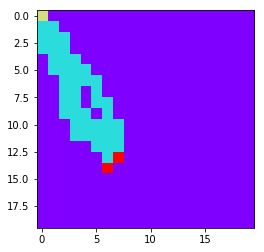

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(env.ground_truth, 'rainbow', interpolation='nearest')
#plt.savefig('ground_truth.png')

# value functionをTD学習で学習する

In [19]:
import numpy as np

#  state value更新回数
mc_step = 300000

# 割引率
gamma = 1. - 1. / float(nb_step)

# 学習率
learning_rate = 0.25

# 考えうる状態の数はground_truthの大きさと同じ（もう少し小さいが、面倒なので同じとする）
value_table = np.zeros_like(env.ground_truth, dtype=float)

# ゴール到達後のstate valueの保存間隔
save_interval = 1000

In [20]:
from tqdm import tqdm

stacked_value_table = []
isSuccessed = False

value_table = np.zeros_like(value_table) # state valueの初期化（念のためループ直前でも初期化する）
try:
    count = 0
    for i in tqdm(range(mc_step)):
        # 状態の初期化
        current_state  = np.zeros(2, dtype=int)

        status = 0
        while status >= 0:
            # 現在の報酬の計算
            reward, status = env.get_reward(current_state)
            
            if status==1:
                isSuccessed = True

            if status>=0:
                # ランダムな行動を取って次の状態を観測する（まだ遷移させない）。
                action = env.random_action()
                next_state = env.transition(current_state, action)

                # TD誤差の計算
                V_current = value_table[current_state[0], current_state[1]]
                V_next = value_table[next_state[0], next_state[1]]
                td_error = reward + gamma * V_next - V_current

                # state valueの更新
                value_table[current_state[0], current_state[1]] = V_current + learning_rate * td_error

                # 状態の遷移（マス目の移動）
                current_state = next_state
                
                if isSuccessed:
                    count += 1
                    if count==save_interval:
                        stacked_value_table.append(np.copy(value_table))
                        count = 0
            
except Exception:
    pass

100%|██████████| 300000/300000 [00:13<00:00, 21857.19it/s]


# 学習過程の可視化
- TD学習では一度ゴールまでたどり着くとその後常にstate valueが更新される。

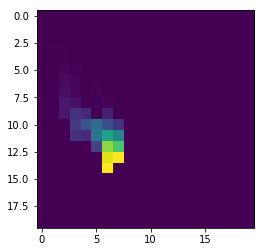

In [21]:
plt.imshow(value_table, interpolation='nearest')
plt.clim(0,1)

In [7]:
len(stacked_value_table)

985

In [ ]:
if isSuccessed:
    nb_show = 30
    nb = 0
    plt.figure(figsize=(10,10*int(len(stacked_value_table[:nb_show])+1)/5.))
    for v in stacked_value_table[:nb_show]:
        nb += 1
        plt.subplot(int(len(stacked_value_table[:nb_show])+1),5,nb)
        plt.imshow(v, interpolation='nearest')
        plt.clim(0,1)

In [ ]:
for i,v in enumerate(stacked_value_table):
    plt.imshow(v, interpolation='nearest')
    plt.clim(0,1)
    plt.title('# of update '+str(i*save_interval).zfill(3))
    plt.savefig('TD_iter_'+str(i).zfill(4)+'.png')
    plt.show()